In [20]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader

DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
NUM_EPOCHS = 100
SNIPPET_LENGTH = 30
SNIPPET_OVERLAP = True



logging.info(f'Number of epochs {NUM_EPOCHS}')
checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")



Created new directory: rnn_training/20251221_094549
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
2025-12-21 09:45:49,360 INFO: Number of epochs 100
2025-12-21 09:45:49,558 INFO: configs shape: (3, 110, 31)
2025-12-21 09:45:49,558 INFO: roi_used shape: (512, 512)
2025-12-21 09:45:49,559 INFO: times shape: (3, 8, 31)
2025-12-21 09:45:49,559 INFO: dfof shape: (3, 15600, 110)


This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [21]:
def setup_logging(dir_name='rnn_training', level=logging.INFO):
    os.makedirs(dir_name, exist_ok=True)
    ts = DATETIME_STAMP
    log_path = os.path.join(dir_name, f'console_{ts}.log')

    logger = logging.getLogger()  # root logger


    logger.setLevel(level)
    # remove existing handlers to avoid duplicate messages
    for h in list(logger.handlers):
        logger.removeHandler(h)

    fmt = logging.Formatter('%(asctime)s %(levelname)s: %(message)s')

    fh = logging.FileHandler(log_path, encoding='utf-8')
    fh.setLevel(level)
    fh.setFormatter(fmt)

    sh = logging.StreamHandler(sys.stdout)
    sh.setLevel(level)
    sh.setFormatter(fmt)

    logger.addHandler(fh)
    logger.addHandler(sh)

    logging.info(f'Logging started. Output file: {log_path}')
    return log_path

# Usage: call once before training
log_file = setup_logging(os.path.join('rnn_training', DATETIME_STAMP))

logging.info(f'Seed: {SEED}')

2025-12-21 09:45:50,785 INFO: Logging started. Output file: rnn_training/20251221_094549/console_20251221_094549.log
2025-12-21 09:45:50,785 INFO: Seed: 42


Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

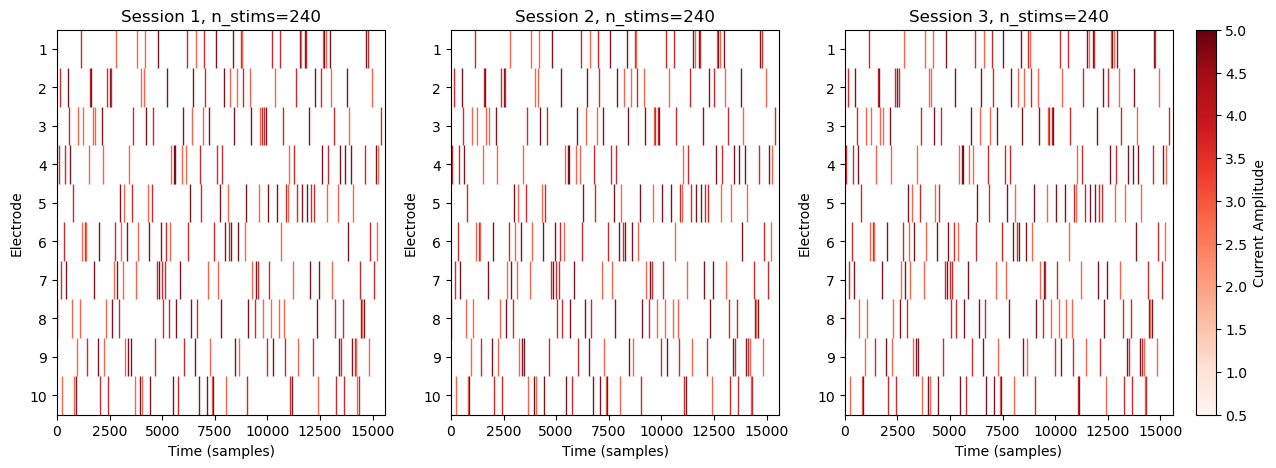

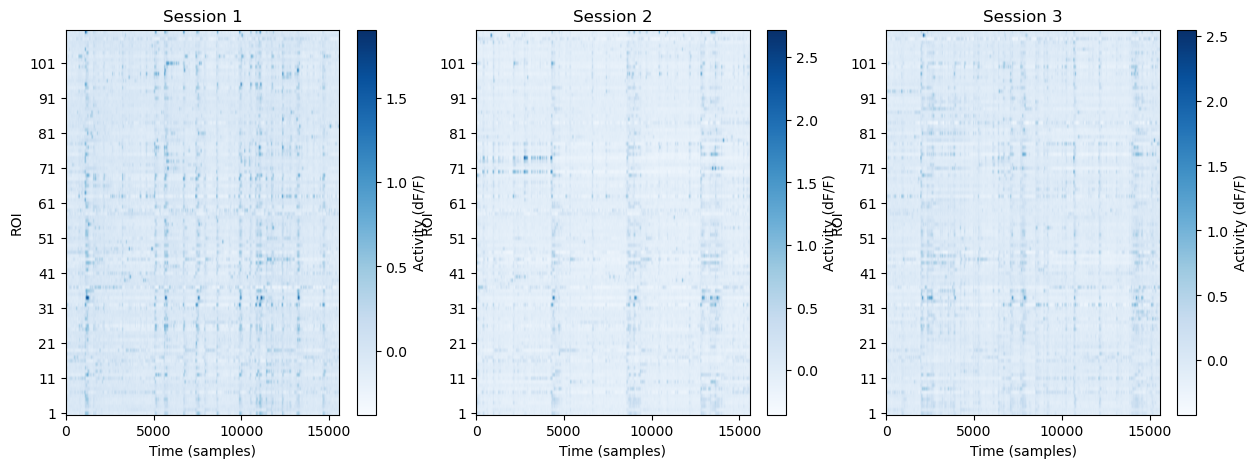

In [22]:
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')

# pairs of (session, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]


plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

In [23]:
from utils import make_snippets

initial_conds, activity_snippets, stim_snippets = make_snippets(dfof, stim_times_sess, SNIPPET_LENGTH, overlap=SNIPPET_OVERLAP)
print (f"Initial conds shape: {initial_conds.shape}")
print (f'Activity snippets shape: {activity_snippets.shape}') # (num_samples, snippet_length, num_rois)
print (f'Stim snippets shape: {stim_snippets.shape}') # (num_samples, snippet_length, num_configs)
logging.info(f"Iniitial conds shape: {initial_conds.shape}")
logging.info(f'Activity snippets shape: {activity_snippets.shape}')
logging.info(f'Stim snippets shape: {stim_snippets.shape}')
logging.info(f'Snippet overlap: {SNIPPET_OVERLAP}')



Initial conds shape: (46713, 110)
Activity snippets shape: (46713, 30, 110)
Stim snippets shape: (46713, 30, 10)
2025-12-21 09:45:55,800 INFO: Iniitial conds shape: (46713, 110)
2025-12-21 09:45:55,801 INFO: Activity snippets shape: (46713, 30, 110)
2025-12-21 09:45:55,802 INFO: Stim snippets shape: (46713, 30, 10)
2025-12-21 09:45:55,802 INFO: Snippet overlap: True


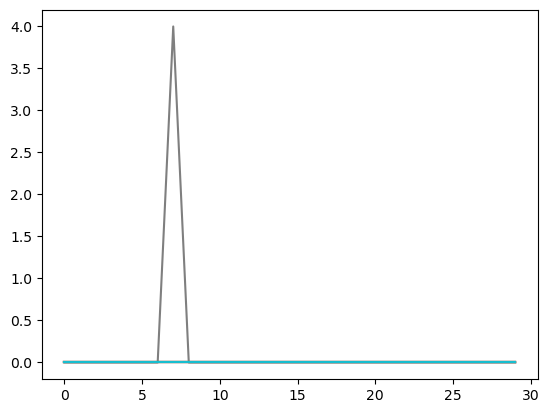

In [24]:
sample = 3
plt.plot(stim_snippets[sample, :, :])
plt.show()

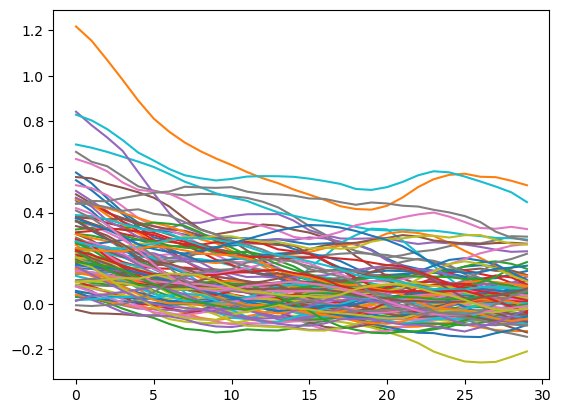

In [25]:
plt.plot(activity_snippets[sample, :, :])
plt.show()

In [26]:
# ----- Split data into training, validation, and test sets -----
n_samples_full = activity_snippets.shape[0]
# init_conds_train, init_conds_temp, stim_train, stim_temp, pred_activity_train, pred_activity_temp = train_test_split(initial_conds, stim_snippets, activity_snippets, test_size=0.3, random_state=SEED)
# init_conds_val, init_conds_test, stim_val, stim_test, pred_activity_val, pred_activity_test = train_test_split(init_conds_temp, stim_temp, pred_activity_temp, test_size=0.5, random_state=SEED)




init_conds_train, stim_train, pred_activity_train, init_conds_val, stim_val, pred_activity_val, init_conds_test, stim_test, pred_activity_test = partition_trials(initial_conds, stim_snippets, activity_snippets, SNIPPET_LENGTH, val_size=0.167, test_size=0.167)

logging.info("Overlapping trials but partitioning timepoints in temporal order")
logging.info(f"Initial conds shape: {init_conds_train.shape}")
logging.info(f"Stim shape: {stim_train.shape}")

# --- prepare data loaders ---
batch_size = 32
logging.info(f'Batch size: {batch_size}')
train_ds = SeqDataset(init_conds_train, stim_train, pred_activity_train)
val_ds = SeqDataset(init_conds_val, stim_val, pred_activity_val)
test_ds = SeqDataset(init_conds_test, stim_test, pred_activity_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()  - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True,)

# python
logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
# --- model, loss, optimizer ---
input_size = stim_train.shape[2]
output_size = pred_activity_train.shape[2]
units = 128
logging.info(f'Train input size: {input_size}')
logging.info(f'Train output size: {output_size}')
logging.info(f'Hidden state size: {units}')
model = RNNModel(input_size=input_size, units=units, output_size=output_size).to(device)

loss_type = "mae"
lr = 0.0005
regularize = 0
if loss_type == 'mse':
    criterion = nn.MSELoss()
elif loss_type == 'mae':
    criterion = nn.L1Loss()
else:
    criterion = nn.MSELoss()



optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=regularize)
logging.info(f"Learning rate {lr}")
logging.info(f"Optimizer: {optimizer}")
logging.info(f"Loss type: {loss_type}")
logging.info(f"Regularization coefficient: {regularize}")

# Example training sample
example_input, example_target = train_ds[0]
# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2025-12-21 09:45:56,447 INFO: Overlapping trials but partitioning timepoints in temporal order
2025-12-21 09:45:56,447 INFO: Initial conds shape: (31081, 110)
2025-12-21 09:45:56,448 INFO: Stim shape: (31081, 30, 10)
2025-12-21 09:45:56,448 INFO: Batch size: 32
2025-12-21 09:45:56,576 INFO: Dataset sizes -> train: 31081, val: 7771, test: 7801
2025-12-21 09:45:56,577 INFO: Train input size: 10
2025-12-21 09:45:56,577 INFO: Train output size: 110
2025-12-21 09:45:56,578 INFO: Hidden state size: 1024
2025-12-21 09:45:56,752 INFO: Learning rate 0.0005
2025-12-21 09:45:56,755 INFO: Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 1e-05
)
2025-12-21 09:45:56,755 INFO: Loss type: mae
2025-12-21 09:45:56,756 INFO: Regularization coefficient: 1e-05


In [27]:
from tqdm.notebook import tqdm
import time

use_amp = True

# --- training loop with epoch timing and progress bars ---
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}
scaler = torch.amp.GradScaler("mps" ,enabled=use_amp)
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc='Epochs', unit='ep')
for epoch in epoch_pbar:
    t0 = time.perf_counter()

    model.train()
    running_loss = 0.0
    for (inputs, activity_initial), targets in tqdm(train_loader, desc=f'Epoch {epoch} Train', leave=False, unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
           outputs = model((inputs, activity_initial))
           loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)
    logging.info(f"Epoch {epoch} Train loss: {train_loss}")

    model.eval()
    val_running = 0.0
    with torch.no_grad(), torch.autocast(
        device_type=device_type,
        dtype=torch.float16,
        enabled=use_amp):
        for (inputs, activity_initial), targets in tqdm(val_loader, desc=f'Epoch {epoch} Val', leave=False, unit='batch'):
            inputs = inputs.to(device)
            activity_initial = activity_initial.to(device)
            targets = targets.to(device)
            outputs = model((inputs, activity_initial))
            val_loss = criterion(outputs, targets)
            val_running += val_loss.item() * inputs.size(0)

    val_loss = val_running / len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    logging.info(f'Epoch {epoch} Validation loss: {val_loss}')


    # stop if no improvement for 5 epochs
    if epoch > 5 and all(history['val_loss'][-i] >= history['val_loss'][-i-1] for i in range(1,6)):
        logging.info ("Early stopping due to no improvement in validation loss for 5 consecutive epochs.")
        break


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_filepath)
        logging.info (f'  Saved best model with val loss {best_val_loss:.6f} to {checkpoint_filepath}')



    epoch_time = time.perf_counter() - t0
    epoch_pbar.set_postfix({'train': f'{train_loss:.6f}', 'val': f'{val_loss:.6f}', 'sec': f'{epoch_time:.2f}'})



Epochs:   0%|          | 0/100 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2025-12-21 09:46:42,918 INFO: Epoch 1 Train loss: 0.09066506660102337


Epoch 1 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2025-12-21 09:46:46,370 INFO: Epoch 1 Validation loss: 0.09775542949133743
2025-12-21 09:46:46,403 INFO:   Saved best model with val loss 0.097755 to rnn_training/20251221_094549/best_model.pth


Epoch 2 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:47:32,058 INFO: Epoch 2 Train loss: 0.09049919110750018


Epoch 2 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:47:35,057 INFO: Epoch 2 Validation loss: 0.09784001178810332


Epoch 3 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:48:21,294 INFO: Epoch 3 Train loss: 0.09065438428261018


Epoch 3 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:48:25,429 INFO: Epoch 3 Validation loss: 0.09773905406436502
2025-12-21 09:48:25,455 INFO:   Saved best model with val loss 0.097739 to rnn_training/20251221_094549/best_model.pth


Epoch 4 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:49:11,449 INFO: Epoch 4 Train loss: 0.090692050260492


Epoch 4 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:49:14,524 INFO: Epoch 4 Validation loss: 0.09774024650912812


Epoch 5 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:50:00,171 INFO: Epoch 5 Train loss: 0.09119835231207592


Epoch 5 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:50:03,322 INFO: Epoch 5 Validation loss: 0.09779463242919208


Epoch 6 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:50:48,909 INFO: Epoch 6 Train loss: 0.09132506535172037


Epoch 6 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:50:51,995 INFO: Epoch 6 Validation loss: 0.09783729250451617


Epoch 7 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:51:37,532 INFO: Epoch 7 Train loss: 0.09232868625742907


Epoch 7 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:51:40,619 INFO: Epoch 7 Validation loss: 0.09832464602060752


Epoch 8 Train:   0%|          | 0/972 [00:00<?, ?batch/s]

2025-12-21 09:52:26,155 INFO: Epoch 8 Train loss: 0.09263469721206363


Epoch 8 Val:   0%|          | 0/243 [00:00<?, ?batch/s]

2025-12-21 09:52:29,109 INFO: Epoch 8 Validation loss: 0.09834402175065311
2025-12-21 09:52:29,109 INFO: Early stopping due to no improvement in validation loss for 5 consecutive epochs.


In [28]:
model = RNNModel(input_size=input_size, units=units, output_size=output_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        loss = criterion(outputs, targets)
        test_running += loss.item() * inputs.size(0)

test_loss = test_running / len(test_loader.dataset)
logging.info(f'Test Loss: {test_loss:.6f}')

Test:   0%|          | 0/244 [00:00<?, ?batch/s]

2025-12-21 09:52:33,203 INFO: Test Loss: 0.098100


In [29]:
model = RNNModel(input_size=input_size, units=units, output_size=output_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0

plot_inputs = []
plot_outputs = []
plot_targets = []
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        plot_inputs.append(inputs.cpu().numpy())
        plot_outputs.append(outputs.cpu().numpy()) # n batches
        plot_targets.append(targets.cpu().numpy())
plot_inputs = np.concatenate(plot_inputs, axis=0)
plot_outputs = np.concatenate(plot_outputs, axis=0)
plot_targets = np.concatenate(plot_targets, axis=0)

print ("Inputs shape: ", plot_inputs.shape)
print ("Predictions shape: ", plot_outputs.shape)
print ("Targets shape: ", plot_targets.shape)




Test:   0%|          | 0/244 [00:00<?, ?batch/s]

Inputs shape:  (7801, 30, 10)
Predictions shape:  (7801, 30, 110)
Targets shape:  (7801, 30, 110)


In [30]:
plt.figure(figsize=(10, 5))
for config, roi in good_pairs: # TODO: Why are only ROIs from a certain range below 30 in the "good pairs"
    print (f"Plotting {roi} prediction over test samples")
    for test_sample in np.random.choice(np.arange(plot_targets.shape[0]), 10, replace=False):
        plt.figure(figsize=(10, 5))
        input = plot_inputs[test_sample, :, :].squeeze()
        stim_times = np.nonzero(input)[0]
        electrodes = np.nonzero(input)[1]
        for i, time in enumerate(stim_times):
            current = input[stim_times[i], electrodes[i]]
            if current == 3:
                plt.axvline(x=time, color='r', linestyle='--')
            elif current == 4:
                plt.axvline(x=time, color='b', linestyle='--')
            elif current == 5:
                plt.axvline(x=time, color='g', linestyle='--')
            else:
                pass
        plt.title("ROI {}, test sample {}: ".format(roi, test_sample))
        # corr = np.corrcoef(plot_outputs[test_sample, :, roi], plot_targets[test_sample, :, roi])
        ax = plt.gca()
        corr_value = np.corrcoef(plot_outputs[test_sample, :, roi],
                                 plot_targets[test_sample, :, roi])[0, 1]
        ax.text(0.98, 0.98, f"corr={corr_value:.3f}", transform=ax.transAxes,
                ha='right', va='top')

        plt.plot(plot_outputs[test_sample, : , roi], 'blue', label="predicted");
        plt.plot(plot_targets[test_sample, :, roi], 'orange', label="ground truth");
        plt.grid()
        plt.legend()
        plt.savefig(os.path.join("rnn_training", DATETIME_STAMP, f"{roi}_{test_sample}.png"))
        plt.close()

Plotting 26 prediction over test samples


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Plotting 22 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 27 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 26 prediction over test samples
Plotting 22 prediction over test samples
Plotting 22 prediction over test samples
Plotting 23 prediction over test samples
Plotting 22 prediction over test samples
Plotting 23 prediction over test samples
Plotting 21 prediction over test samples
Plotting 21 prediction over test samples
Plotting 31 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 27 prediction over test samples
Plotting 31 pred

<Figure size 1000x500 with 0 Axes>

In [31]:
plot_outputs.shape


(7801, 30, 110)

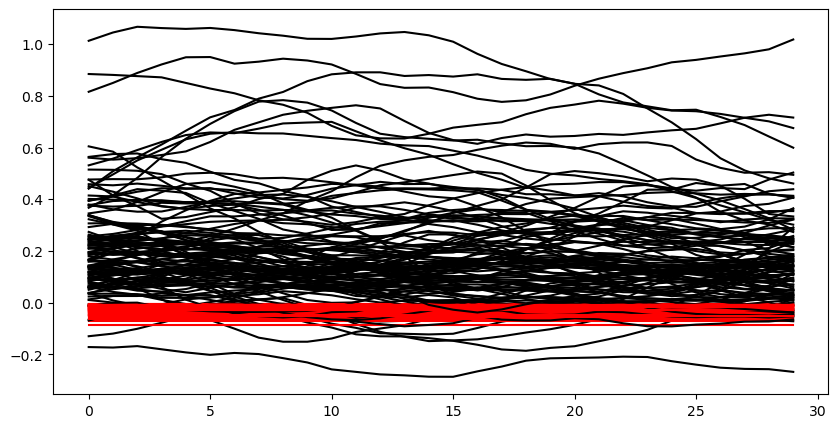

In [32]:
plt.figure(figsize=(10, 5))
for roi in range(110):
    plt.plot(plot_outputs[0,  :,  roi], 'r')
    plt.plot(plot_targets[0,  :,  roi], 'k')


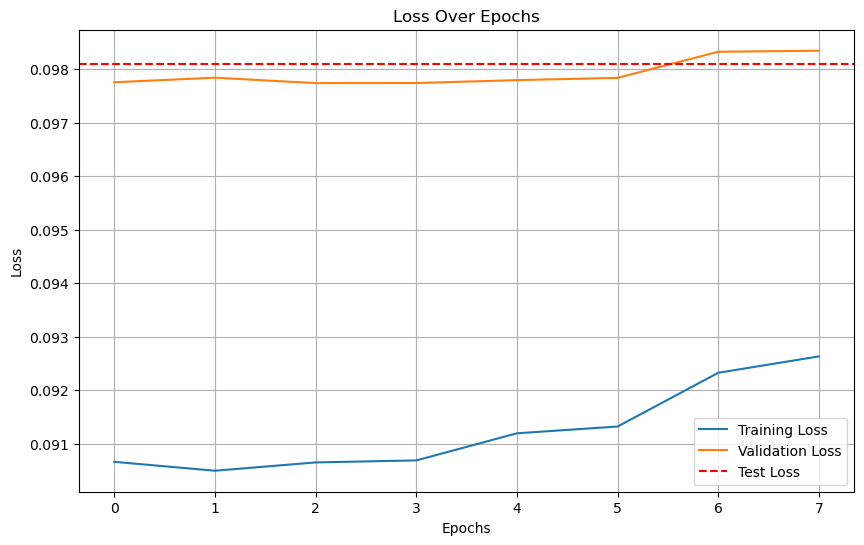

In [33]:
# ----- Plot training, validation, and test loss -----
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'rnn_training/{DATETIME_STAMP}/loss_over_epochs.png')
plt.show()

In [16]:
stim_snippets.shape # should be (n_snippets, snippet_length, n_configs, 1)


(46713, 30, 10)

In [17]:
activity_snippets.shape # should be (n_snippets, snippet_length, n_rois)

(46713, 30, 110)

In [18]:
times[0][0]
configs[0][0].shape

(31,)

In [19]:
# ----- Analyze the fit model -----

model = RNNModel(input_size=input_size, units=units, output_size=output_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
# test on a training snippet for shape matching
# create a batch of size 1: inputs shape (1, seq_len, input_size)
inputs = torch.from_numpy(np.expand_dims(stim_snippets[0].astype(np.float32), axis=0)).to(device)

# activity_initial must be the first timestep of the activity snippet, shape (1, output_size)
activity_initial = torch.from_numpy(np.expand_dims(activity_snippets[0][0].astype(np.float32), axis=0)).to(device)
print ("Example output: ",  model((inputs, activity_initial)).shape)

example_roi = 31  # Index of the example ROI to plot
potential_activating_configs = [7, 8, 9, 26, 27, 28, 29, 30]
print ("Stim snippets: ", stim_snippets.shape)

prediction_length = SNIPPET_LENGTH


generated_activity = []
config_list = []
for config in range(1, 32):
    if config != 31:
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
    else:
        electrode = 0  # no stim
        current = 0
    stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]), dtype=np.float32)
    # select electrodes to activate based on config
    stim_input[0, 0, electrode] = current  # Set the current config
    activity_input = np.expand_dims(initial_condition.astype(np.float32), axis=0)

    # convert to tensors and move to device
    inputs_t = torch.from_numpy(stim_input).to(device)
    activity_t = torch.from_numpy(activity_input).to(device)

    with torch.no_grad():
        outputs = model((inputs_t, activity_t))  # (batch, seq_len, output_size)
    generated = outputs.cpu().numpy()
    generated_activity.append(generated[0])
    config_list.append(config)

generated_activity = np.array(generated_activity)

# ----- Plot the activity of the example ROI -----
plt.figure(figsize=(10, 6))
for isample in range(generated_activity.shape[0]):
    if config_list[isample] in potential_activating_configs:
        color = 'r'
    else:
        color = 'b'
        
    plt.plot(generated_activity[isample, :, example_roi-1], alpha=0.3, color=color)

plt.title(f'Activity of ROI {example_roi} for all configs')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True)
plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}.png')
plt.show()

Example output:  torch.Size([1, 30, 110])
Stim snippets:  (46713, 30, 10)


NameError: name 'initial_condition' is not defined

In [ ]:
# ----- Analyze the fit model -----
prediction_length = SNIPPET_LENGTH  # Length of the prediction snippet

for config, roi in good_pairs:
    electrode = (config-1) // 3
    current = (config-1)%3 + 3
    generated_activity = []
    electrode = 1 # Electrode to stimulate

    config_list = []
    idx = 0
    for current in np.arange(2, 6, 0.1):

        stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]))
        stim_input[0, 0, electrode] = current  # Set the current config
        activity_input = np.expand_dims(initial_condition, axis=0)  # Add batch dimension
        generated = model((stim_input, activity_input))

        generated_activity.append(generated[0, :, :].detach().cpu().numpy())
        if current in [3, 4, 5] and electrode < 10:
            config_list.append(idx)
        else:
            config_list.append(-1)
        idx += 1
    generated_activity = np.array(generated_activity)

    # ----- Plot the activity of the example ROI -----
    plt.figure(figsize=(10, 6))
    for isample in range(generated_activity.shape[0]):
        if config_list[isample] in potential_activating_configs:
            color = 'r'
        else:
            color = 'b'

        plt.plot(generated_activity[isample, :, example_roi-1], alpha=0.3, color=color)

    plt.title(f'Activity of ROI {example_roi} for all configs with electrode {electrode}')
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.grid(True)
    plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}_current_sweep.png')

    # plot activtiy at time 't' vs current
    plt.figure(figsize=(10, 6))
    time_point = 10
    activities = generated_activity[:, time_point, example_roi-1]
    currents = np.arange(2, 6, 0.1)
    plt.plot(currents, activities, 'o-')
    # plt.axvline([3, 4, 5], [-1, 1], color='r', linestyle='--')
    plt.title(f'Activity of ROI {example_roi} at time {time_point} vs Current')
    plt.xlabel('Current')
    plt.ylabel('Activity')
    plt.grid(True)
    plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}_current_sweep.png')

    # plt.show()

In [ ]:
# what does the jacobian look like?

# # pairs of (session, roi) that are known to have good responses
##good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
 #             (12,26),(13,22),(14,22),(14,23),
  #            (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
  #            (29,26),(29,31),(30,26),(30,27),(30,31)]

example_roi = 31  # Index of the example ROI to plot
config = 30
electrode = (config-1) // 3
current = (config-1)%3 + 3


prediction_length = SNIPPET_LENGTH  # Length of the prediction snippet
initial_condition = 0 +  0 * activity_snippets[200, 0,  :].astype(np.float32) # Initial condition

stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]), dtype=np.float32)
stim_input[0, 0, electrode] = current  # Set the current config
activity_input = np.expand_dims(initial_condition, axis=0)  # Add batch dimension
stim_input_t = torch.from_numpy(stim_input).to(device).requires_grad_(True)
activity_input_t = torch.from_numpy(activity_input).to(device)
generated = model((stim_input_t, activity_input_t))
roi_activity = generated[0, :, example_roi-1]
print (roi_activity.shape)
jacobian = []
for t in range(prediction_length):
    grad_outputs = torch.zeros_like(roi_activity)
    grad_outputs[t] = 1.0
    grads = torch.autograd.grad(outputs=roi_activity, inputs=stim_input_t,
                                grad_outputs=grad_outputs,
                                retain_graph=True)
    # grads is a tuple (one entry per input). For a single Tensor input:
    grad_tensor = grads[0]  # Tensor or None; expected shape (1, prediction_length, n_electrodes)

    # handle possible None and extract batch-0 slice (seq_len, n_electrodes)
    if grad_tensor is None:
        jacobian.append(np.zeros((prediction_length, stim_input_t.shape[2]), dtype=np.float32))
    else:
        jacobian.append(grad_tensor[0].detach().cpu().numpy())
jacobian = np.array(jacobian)  # shape (prediction_length, prediction_length, n_electrodes)
print (f'Jacobian shape: {jacobian.shape}')
# plot jacobian as heatmap
plt.figure(figsize=(10, 6))
plt.imshow(jacobian[:, 0, :].T, aspect='auto', cmap='Blues', origin='lower')
plt.colorbar(label='Sensitivity')
plt.title(f'Jacobian of ROI {example_roi} activity w.r.t. stim current {current} at electrode {electrode} at time 0')
plt.xlabel('Time')
plt.ylabel('Electrode')
plt.yticks(np.arange(stim_input.shape[2]), labels=[str(i+1) for i in range(stim_input.shape[2])])
plt.grid()
plt.savefig(f'rnn_training/{DATETIME_STAMP}/jacobian_roi{example_roi}.png')
plt.show()


In [ ]:
# Perform UMAP on the hidden states
model.eval()
hidden_states = []
currents = []
electrodes = []
configs_tracker = []

with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Extract Hidden States', unit='batch'):
        #inputs shape  batch, time, electrodes
        batch_currents = []
        batch_electrodes = []
        batch_configs = []
        t_configs = []
        for idx in range(inputs.shape[0]):
            # look at each sample in batch separately for simplicity but later vectorize
            config_vector = inputs[idx,:,:].cpu().numpy()

            stim_times = np.nonzero(config_vector)[0]
            electrodes_used = np.nonzero(config_vector)[1]

            for t, e in zip(stim_times, electrodes_used):
                # verify config number stays same through all t in a snippet
                current = config_vector[t, e]
                # print (f'Time {t}, Electrode {e}, Current {current}')
                config_num = e * 3 + (int(current) - 3) + 1 # map back to config number
                t_configs.append(config_num)
                print (t_configs)
            # print (stim_times, electrodes_used, t_configs)
            assert all(c == t_configs[0] for c in t_configs), "Multiple configs in one snippet!"
            batch_configs.append(t_configs[0])

            configs_tracker.append(batch_configs)
            batch_currents.append(config_vector[t, e]) # should be batch size
            batch_electrodes.append(e) # should be batch size
        currents.append(batch_currents)
        electrodes.append(batch_electrodes)

        inputs = inputs.to(device)
        currents.append(inputs)
        activity_initial = activity_initial.to(device)
        # Project initial activity to hidden state
        h0 = model.initial_state_projection(activity_initial).unsqueeze(0).contiguous()
        out, _ = model.rnn(inputs, h0)
        hidden_states.append(out.cpu().numpy())
print (len(hidden_states))
hidden_states = np.concatenate(hidden_states, axis=0)  # shape (n_samples, seq_len, units)
# print (len(currents), len(electrodes))
# print (len(currents[0]), len(electrodes[0]))
print (len(configs_tracker))
print (len(hidden_states))

assert len(currents) == len(hidden_states)
assert len(stim_snippets) == len(hidden_states)
n_samples, seq_len, units = hidden_states.shape
# hidden_states_reshaped = hidden_states.reshape(-1, units)  # shape (n_samples * seq_len, units)

In [ ]:
print (hidden_states.shape)
print (len(configs_tracker))
print (n_samples)

In [ ]:
import umap
umap = umap.UMAP(n_components=2, random_state=SEED)
hidden_states_2d = umap.fit_transform(hidden_states[:, 60, :])  # shape (n_samples * seq_len, 2)
# Plot UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], s=1, alpha=0.5)
plt.title('UMAP of RNN Hidden States')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid()
plt.savefig(f'rnn_training/{DATETIME_STAMP}/umap_hidden_states.png')
plt.show()


In [ ]:
# Make ROI visual
model = RNNModel(input_size=input_size, units=units, output_size=output_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
num_rois = 110 # TODO: Not hardcode rois/time
for roi in range(num_rois):
    for t in range(1, 15601, SNIPPET_LENGTH):
        init_cond = activity[0][0][t-1 :].astype(np.float32)


In [ ]:
# ============================
# ROI activation video (neutral background)
# ============================

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import animation

session = 0
mat = scipy.io.loadmat("data_with_rois_labeled.mat")
labelMat = np.squeeze(np.array(mat["labelMat"]))
raw_dfof = mat["dfof"][0, session]
times = np.squeeze(mat.get("times", None)[session])
numNeurons = int(np.array(mat["numNeurons"]))

# -------- Convert dfof safely --------
if raw_dfof.dtype == object:
    cell_list = raw_dfof.ravel()
    dfof = np.vstack([np.squeeze(cell) for cell in cell_list])
else:
    dfof = np.array(raw_dfof, dtype=float)

if dfof.shape[0] != numNeurons:
    dfof = dfof.T

T = dfof.shape[1]
print(f"Loaded {numNeurons} ROIs, {T} timepoints")

# -------- Normalize per neuron --------
mean = dfof.mean(axis=1, keepdims=True)
std = dfof.std(axis=1, keepdims=True)
dfof = (dfof - mean) / (std + 1e-8)

# -------- ROI masks --------
roi_ids = np.unique(labelMat)
roi_ids = roi_ids[roi_ids > 0]

roi_masks = {roi: (labelMat == roi) for roi in roi_ids}
roi_mask_all = labelMat > 0

# -------- Figure setup --------
fig, ax = plt.subplots(figsize=(3, 3))

# Background (neutral gray)
bg = ax.imshow(
    np.zeros_like(labelMat),
    cmap="gray",
    vmin=0,
    vmax=1,
)

# Foreground ROI activation (masked outside ROIs)
img = ax.imshow(
    np.ma.masked_where(~roi_mask_all, np.zeros_like(labelMat, dtype=float)),
    cmap="hot",
    vmin=np.percentile(dfof, 5),
    vmax=np.percentile(dfof, 95),
)

ax.axis("off")
cbar = plt.colorbar(img, ax=ax, fraction=0.046)
cbar.set_label("ΔF/F (z-scored)")

title = ax.set_title("")

# -------- Update function --------
def update(frame):
    activation = np.zeros_like(labelMat, dtype=float)

    for roi in roi_ids:
        roi_idx = int(roi) - 1
        if roi_idx < dfof.shape[0]:
            activation[roi_masks[roi]] = dfof[roi_idx, frame]

    img.set_data(np.ma.masked_where(~roi_mask_all, activation))

    title.set_text(f"Frame {frame}")

    return (img,)

# -------- Animate --------
frame_step = 5
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 200, frame_step),
    interval=50,
    blit=True,
)

# -------- Optional save --------
ani.save("true_roi_activation.mp4", writer="ffmpeg", dpi=60, fps=10,     extra_args=["-preset", "ultrafast", "-crf", "28"],)
